# Housing Price Prediction Project

This notebook demonstrates a complete workflow for predicting housing prices using the provided dataset (`Houses.csv`). The workflow includes:
- Data Loading
- Exploratory Data Analysis (EDA) with graphs
- Data Cleaning
- Feature Engineering
- Data Splitting
- Model Training (Linear Regression, Random Forest, and XGBoost)
- Model Evaluation
- Making Predictions



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (adjust the file path if needed)
df = pd.read_csv('Houses.csv', encoding='iso-8859-2')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
df.info()

# Show the first few rows
display(df.head())


Dataset Shape: (23764, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23764 entries, 0 to 23763
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  23764 non-null  int64  
 1   address     23764 non-null  object 
 2   city        23764 non-null  object 
 3   floor       23764 non-null  float64
 4   id          23764 non-null  float64
 5   latitude    23764 non-null  float64
 6   longitude   23764 non-null  float64
 7   price       23764 non-null  float64
 8   rooms       23764 non-null  float64
 9   sq          23764 non-null  float64
 10  year        23764 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznań,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


## Exploratory Data Analysis (EDA)

We will now explore the dataset with several graphs:
- **Histogram of House Prices**: Understand the distribution of prices.
- **Scatter Plot of Price vs. Square Footage**: See how area relates to price.
- **Correlation Heatmap**: View relationships between numerical features.
- **Boxplot of House Prices by City**: Compare price distributions across cities.


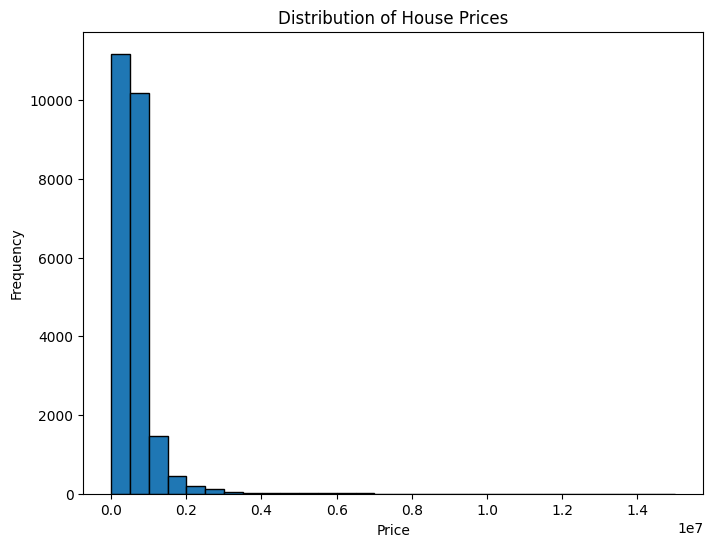

In [2]:
plt.figure(figsize=(8, 6))
plt.hist(df['price'], bins=30, edgecolor='black')
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


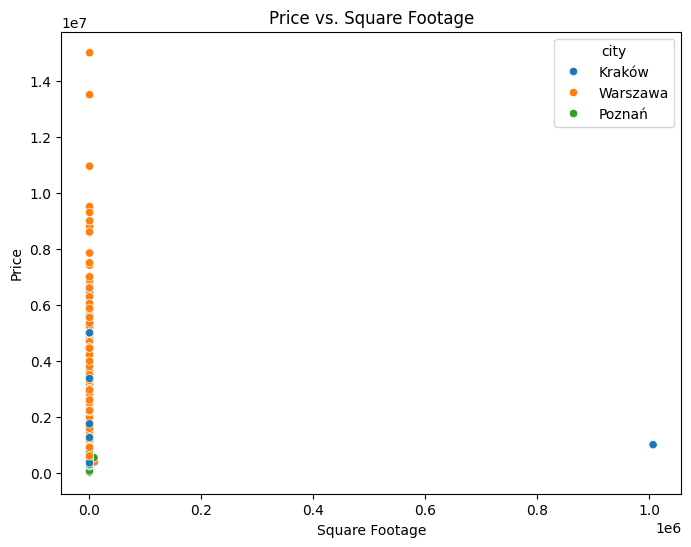

In [3]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sq', y='price', hue='city', data=df)
plt.title("Price vs. Square Footage")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.show()


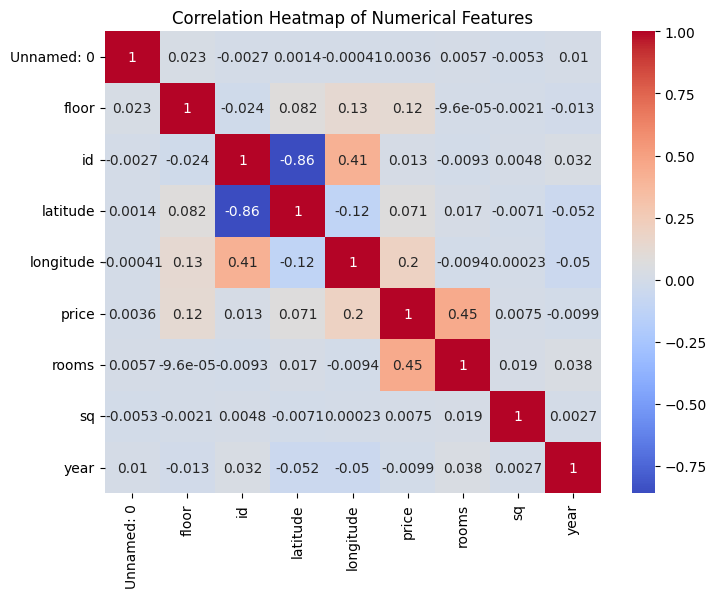

In [6]:
# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix on numeric data
corr_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


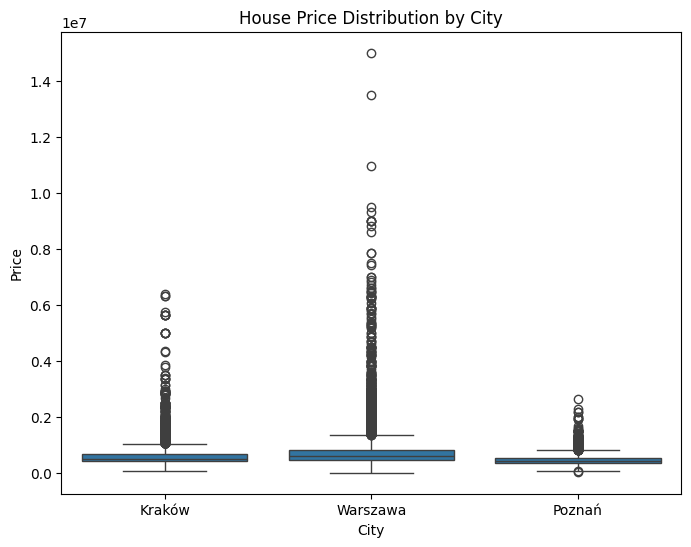

In [5]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='city', y='price', data=df)
plt.title("House Price Distribution by City")
plt.xlabel("City")
plt.ylabel("Price")
plt.show()


## Data Cleaning

In this section, we address potential data quality issues:
- Drop columns that are not needed for prediction (like unique IDs or address text).
- Remove extreme outliers (e.g., unrealistic area values, extremely low prices, or invalid years).
- Correct data types for consistency.


In [7]:
# Drop columns that are not required (e.g., 'Unnamed: 0', 'id', 'address')
df = df.drop(columns=['Unnamed: 0', 'id', 'address'])

# Remove outlier records based on domain knowledge:
# - Remove records with area (sq) larger than a plausible threshold (e.g., >500 m^2)
df = df[df['sq'] < 500]
# - Remove records with extremely low prices (<50,000)
df = df[df['price'] > 50000]
# - Remove records with invalid 'year' (e.g., future years)
df = df[df['year'] <= 2025]
# (Optionally, remove any other suspicious records, such as invalid coordinates)
# For example, if a longitude is far off (e.g., <10), drop it:
df = df[df['longitude'] > 10]

# Fix 'year' values that might be in two-digit format
df['year'] = df['year'].apply(lambda x: x + 1900 if x < 100 else x)

# Convert data types of certain columns to int for consistency
df['year'] = df['year'].astype(int)
df['floor'] = df['floor'].astype(int)
df['rooms'] = df['rooms'].astype(int)

print("After cleaning, dataset shape:", df.shape)
display(df.head())


After cleaning, dataset shape: (23757, 8)


,city,floor,latitude,longitude,price,rooms,sq,year
0,Kraków,2,50.049224,19.970379,749000.0,3,74.05,2021
1,Warszawa,3,52.249775,21.106886,240548.0,1,24.38,2021
2,Kraków,2,50.066964,19.920025,427000.0,2,37.00,1970
3,Poznań,2,52.404212,16.882542,1290000.0,5,166.00,1935
4,Warszawa,1,52.212225,20.972630,996000.0,5,105.00,2020


## Feature Engineering

We now create new features and transform existing ones:
- **House Age**: Instead of the year built, compute the house age as `age = current_year - year`.
- **One-Hot Encode the City**: Convert the categorical 'city' variable into dummy variables.
- **Drop Unused Location Data**: We'll drop latitude and longitude for simplicity.


In [8]:
# Create new feature: house age (using 2025 as the reference year)
current_year = 2025
df['age'] = current_year - df['year']
df = df.drop(columns='year')  # drop original year column

# Drop latitude and longitude for simplicity
df = df.drop(columns=['latitude', 'longitude'])

# One-hot encode 'city'. The parameter drop_first=True drops one category (e.g., Kraków) to avoid dummy variable trap.
df = pd.get_dummies(df, columns=['city'], drop_first=True)

# Check the new feature set
display(df.head())


,floor,price,rooms,sq,age,city_Poznań,city_Warszawa
0,2,749000.0,3,74.05,4,False,False
1,3,240548.0,1,24.38,4,False,True
2,2,427000.0,2,37.00,55,False,False
3,2,1290000.0,5,166.00,90,True,False
4,1,996000.0,5,105.00,5,False,True


## Data Splitting

Next, we separate the features and target variable (`price`), then split the dataset into training and testing sets (80% training, 20% testing).


In [9]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 19005
Test set size: 4752


## Model Training

We will train three models:
1. **Linear Regression** as a baseline.
2. **Random Forest Regressor** for a non-linear ensemble approach.
3. **XGBoost Regressor** for boosted decision trees.

We'll use scikit-learn and xgboost libraries.


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
lin_reg = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

# Train the models on the training data
lin_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Model Evaluation

We evaluate the models on the test set using these metrics:
- **Mean Absolute Error (MAE)**
- **Root Mean Squared Error (RMSE)**
- **R² (Coefficient of Determination)**

We also visualize the Actual vs. Predicted values for one of the models (Random Forest).


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.0f}, RMSE: {rmse:.0f}, R²: {r2:.2f}")

print_metrics("Linear Regression", y_test, y_pred_lin)
print_metrics("Random Forest", y_test, y_pred_rf)
print_metrics("XGBoost", y_test, y_pred_xgb)


Linear Regression -> MAE: 160485, RMSE: 324558, R²: 0.60
Random Forest -> MAE: 91478, RMSE: 267676, R²: 0.73
XGBoost -> MAE: 107630, RMSE: 278619, R²: 0.71


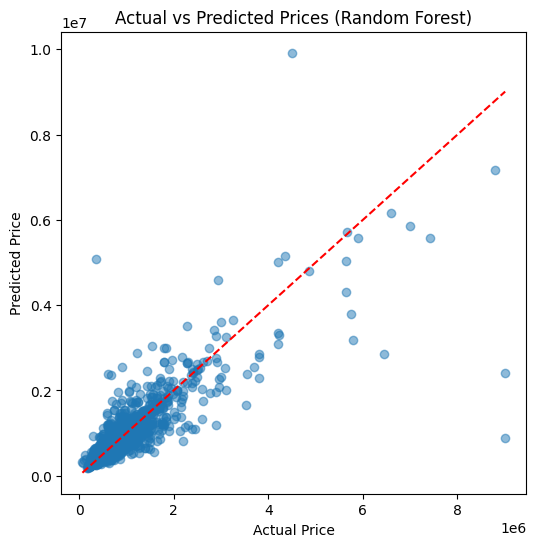

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.show()


## Making Predictions

Finally, let's make predictions on a few sample houses from the test set and compare the actual prices with the predicted prices from the Random Forest model.


In [14]:
# Create a DataFrame with actual and predicted prices for the first 5 test samples
sample_results = X_test.copy()
sample_results['Actual Price'] = y_test
sample_results['Predicted Price'] = y_pred_rf

# Show a few rows for comparison
display(sample_results[['Actual Price', 'Predicted Price']].head())


,Actual Price,Predicted Price
23172,950000.0,954311.666667
15208,519000.0,495156.190476
23347,543071.0,453666.794600
18496,479000.0,475727.200000
2789,270000.0,302585.640000


# Conclusion

In this notebook, we:
- Loaded and explored a housing dataset.
- Visualized key relationships using histograms, scatter plots, heatmaps, and boxplots.
- Cleaned the data and engineered new features.
- Built and compared three models for predicting house prices.
- Evaluated the models and visualized the predictions.

This complete workflow can serve as a foundation for further enhancements (like hyperparameter tuning or including additional features) to improve prediction accuracy.
